In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"

In [ ]:
llm = init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001B12ADEBFE0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001B12B303F80>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
class State(TypedDict):
    messages:Annotated[list[BaseMessage], add_messages]

In [5]:
# Graph with tool call
# Graph with tool call
@tool
def add(x: float, y: float):
    """Adds two numbers."""
    return x + y

tools=[add]
tool_node = ToolNode([add])

llm_with_tools = llm.bind_tools([add])

def call_llm_model(state:State):
    """Call the LLM model with the current state."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return response

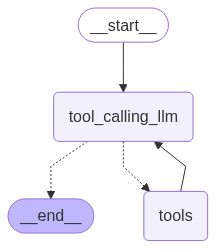

In [6]:
## Node definition
def call_llm_model(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}
## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
response=graph.invoke({"messages":"What is machine learning"})
response

{'messages': [HumanMessage(content='What is machine learning', additional_kwargs={}, response_metadata={}, id='3ffc24b8-0bec-4e85-97fa-dee7881e483c'),
  AIMessage(content='Machine learning is a branch of artificial intelligence (AI) that involves the use of algorithms and statistical models to enable machines to learn from data, make decisions, and improve their performance on a task without being explicitly programmed.\n\nIn traditional programming, a computer is given a set of instructions that it follows to perform a specific task. In contrast, machine learning algorithms are trained on a dataset, and they can learn to recognize patterns, make predictions, and classify data without being explicitly told how to do so.\n\nThere are several key concepts in machine learning:\n\n1. **Supervised learning**: The algorithm is trained on a labeled dataset, where the correct output is already known.\n2. **Unsupervised learning**: The algorithm is trained on an unlabeled dataset, and it must f

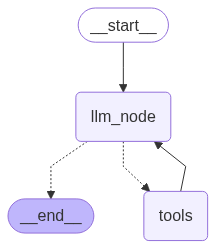

{'messages': [HumanMessage(content='what is 7 plus 20', additional_kwargs={}, response_metadata={}, id='2defde1d-7ad5-48bd-a956-4ae1c99700a2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '14qwdrb1j', 'function': {'arguments': '{"x":7,"y":20}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 219, 'total_tokens': 237, 'completion_time': 0.032571578, 'prompt_time': 0.012965949, 'queue_time': 0.08696148399999999, 'total_time': 0.045537527}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--eda080ba-db2a-4d3d-9af5-9b3f5edd00b7-0', tool_calls=[{'name': 'add', 'args': {'x': 7, 'y': 20}, 'id': '14qwdrb1j', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 18, 'total_tokens': 237}),
  ToolMessage(content='27.0', name='add', id='7e02e021-91f6-46f8-a26d-1b43b6883ecf', tool_call_id='14qwdrb1j'),
  

In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

# إعداد المفاتيح من البيئة
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"

# تهيئة نموذج الدردشة
llm = init_chat_model("groq:llama-3.1-8b-instant")

# تعريف الحالة
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

# تعريف أداة الجمع
@tool
def add(x: float, y: float):
    """Adds two numbers."""
    return x + y

tools = [add]

# ربط النموذج بالأدوات
llm_with_tools = llm.bind_tools(tools)

# تعريف دالة العقدة التي تستدعي النموذج
def call_llm_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# بناء المخطط
builder = StateGraph(State)
builder.add_node("llm_node", call_llm_model)
builder.add_node("tools", ToolNode(tools))  # <-- هنا اسم العقدة يجب أن يكون "tools"

# إضافة الحواف
builder.add_edge(START, "llm_node")
builder.add_conditional_edges("llm_node", tools_condition)
builder.add_edge("tools", "llm_node")  # <-- هنا أيضًا "tools"
builder.add_edge("llm_node", END)

# تجميع المخطط
graph = builder.compile()

# عرض المخطط
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

# تجربة المخطط
response = graph.invoke({"messages": "what is 7 plus 20"})
response
